In [1]:
# SPDX-License-Identifier: MIT# Copyright (c) 2025 Alexander Steiger#!/usr/bin/python3
import fertigationMapfunctions as fMf

import json
import os
import shutil
import io
import zipfile
import requests
import pandas as pd
import numpy as np
#import ssl
import urllib.request
import geopandas as gpd 
from datetime import date
#from sqlalchemy import create_engine, text
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

                                
uni           = ["ru","ugent","bursa"]
field         = ["Kassow","Blondel-3","Karacabey"]

## Settings (order: ru, ugent, bursa)
depth         = [200, 300, 600] # Irrigation depth/root depth in mm
fill_up_rate  = [0.9, 0.9, 0.9] # Fill up rate in percent of field capacity (e.g. 0.9 = 90%)
MAD_set       = [0.5,0.5,0.5]   # Management allowance depletion in percent (e.g. 0.5 = 50%)
irr_user_rate = [30,30,40]
fer_user_rate = [500,500,500]   # Fertilization user rate in l/ha

# In the MZs is either the column: 
# "fertility" (L, ML, M, MH, H)             --> fertility of each MZ
# "fer_l_ha"  (eg. 209, 384, 732, 907, 558) --> fixed rate for each MZ

# Fertility related to fertilization rates (eg. L (Low fertility) = 1.5*fer_rate)
fer_rates_rel = {"ru":   {"L" : 1.5,"ML": 1.25,"M" : 1.0,"MH": 0.75,"H" : 0.5},
                 "ugent":{"L" : 1.5,"ML": 1.25,"M" : 1.0,"MH": 0.75,"H" : 0.5},
                 "bursa":{"L" : 1.5,"ML": 1.25,"M" : 1.0,"MH": 0.75,"H" : 0.5}} #L = Low fertility

# Alternatively the final fertilization rate can also be set here:
use_absolute_rates = [False,False,True]
fer_rates_abs = {"ru":   {1 : 200, 2: 300, 3 : 550, 4: 732, 5 : 906, 99: 555},
                 "ugent":{1 : 200, 2: 300, 3 : 550, 4: 732, 5 : 906, 99: 555},
                 "bursa":{1 : 209, 2: 384, 3 : 732, 4: 907, 5 : 558, 99: 558}}

# Priorities: "use_absolute_rates" > "fer_l_ha" from MZ > "fertility" from MZ

Irr_min        = [20,20,20]
Irr_max        = [50,50,40]

ModuleNotFoundError: No module named 'geopandas'

******************* MZ_gdf *******************
ru_mz_as_grid
http://geoportal.addferti.eu/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typename=geonode%3Aru_mz_as_grid&outputFormat=json
Transform crs of ru_mz_as_grid from 4326 to 4326
['id' 'ogc_fid' 'fer_mz' 'fc' 'pwp' 'vw_g_cm3' 'fertility' 'device_id'
 'irr_mz' 'geometry']
******************* rain_df *******************
CRS of current_ru_weather_forecast :  4326
['date' 'rain' 'humidity' 'dew_point' 'wind_speed' 'clouds' 'uvi' 'temp'
 'lon' 'lat' 'location']
******************* Soil Moisture Sensors *******************
CRS of current_ru_soil_moisture :  4326
['device_id' 'time' 'soil_temp' 'soil_mc' 'soil_ec' 'geometry']


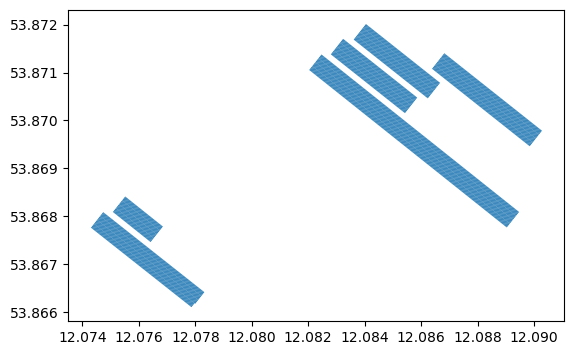

In [17]:
MZ_gdf = None
fer_MZ_gdf = None

# Loop through specific indices in the array [0,1,2] = [ru,ugent,bursa]
for  i  in  [0]:
    #irr_MZ_gdf    =  fMf.get_MZ(uni[i],"irr")
    #fer_MZ_gdf    =  fMf.get_MZ(uni[i],"fer")
    MZ_gdf        =  fMf.get_MZ(uni[i])
    rain_df       =  fMf.get_rain(uni[i])
    CMC_gdf       =  fMf.get_current_SMC(uni[i])  
    
    #irr_MZ_gdf    =  fMf.get_MZ("pisa","irr")        
    #rain_df       =  fMf.get_rain("ru")
    #CMC_gdf       =  fMf.get_current_SMC("pisa")  

#print(MZ_gdf.columns.values)
#print(CMC_gdf)
#print(rain_df)
#print(CMC_gdf.columns.values)

    ## Paths for output files
    folder      = "outputFiles/" + uni[i] + "_application_map"
    filename    = "application_map_" + uni[i]
    pathAndName = folder + "/" + filename
    pathAndName

In [18]:
print(CMC_gdf)

    device_id                time  soil_temp  soil_mc  soil_ec  \
0   ru-lse-01 2023-12-31 03:12:01      17.96    17.00        0   
1   ru-lse-02 2023-12-31 20:35:58      18.26    18.00        0   
2   ru-lse-03 2023-12-31 10:11:07      18.05    26.00        0   
3   ru-lse-04 2023-12-30 12:19:15      18.18    27.00        0   
4   ru-lse-05 2023-12-30 10:25:50      18.08    17.00        0   
5   ru-lse-06 2023-12-22 20:11:15      18.29    18.00        0   
6   ru-lse-07 2023-12-22 20:35:50      18.18    18.00        0   
7   ru-lse-08 2023-12-22 20:19:08      18.20    17.00        0   
8   ru-lse-09 2023-12-28 20:30:27      18.16    21.00        0   
9   ru-lse-10 2023-12-22 20:22:20      18.25    10.00        0   
10  ru-lse-11 2023-12-22 07:38:32      18.29    15.00        0   
11  ru-lse-12 2023-08-26 17:15:25      19.50    17.85       45   
12  ru-lse-13 2023-12-22 20:32:43      18.09    15.00        0   
13  ru-lse-14 2023-12-22 19:36:36      18.19    16.00        0   
14  ru-lse

In [13]:
    ## Merge all the data
    if fer_MZ_gdf is not None:
        print("join irr_MZ and fer_MZ")
        MZ_gdf = irr_MZ_gdf.sjoin(fer_MZ_gdf, how='left', op='contains')
        
    if MZ_gdf is None:
        MZ_gdf = irr_MZ_gdf
    
    CMC_df = CMC_gdf.drop('geometry',axis=1) #tranform gdf to a df
    
    # Left attribute join on 'device_id'
    gdf = MZ_gdf.merge(CMC_df, on='device_id', how='left')
    
    # drop some columns (if they exist)
    if 'id' in gdf.columns:
        gdf = gdf.drop('id', axis=1)        
    if 'id_left' in gdf.columns:
        gdf = gdf.drop('id_left', axis=1)
    if 'fid_left' in gdf.columns:
        gdf = gdf.drop('fid_left', axis=1)
    if 'id_right' in gdf.columns:
        gdf = gdf.drop('id_right', axis=1) 
    if 'fid_right' in gdf.columns:
        gdf = gdf.drop('fid_right', axis=1)
    if 'index_right' in gdf.columns:
        gdf = gdf.drop('index_right', axis=1)
    if 'soil_gdfemp' in gdf.columns:
        gdf = gdf.drop('soil_temp', axis=1)
    if 'soil_ec' in gdf.columns:
        gdf = gdf.drop('soil_ec', axis=1)
    if 'ogc_fid' in gdf.columns:
        gdf = gdf.drop('ogc_fid', axis=1)
    if 'fid' in gdf.columns:
        print("yes")
        gdf = gdf.drop('fid', axis=1)
    
    gdf['fc'] = pd.to_numeric(gdf['fc'])
    gdf['pwp'] = pd.to_numeric(gdf['pwp'])
    gdf['vw_g_cm3'] = pd.to_numeric(gdf['vw_g_cm3'])
    
    # rename the columns
    gdf = gdf.rename(columns={"soil_mc":"smc"})
    gdf = gdf.drop_duplicates()
    print(gdf.columns.values)
    #print(CMC_df.columns.values)
    #print(gdf.head())

['fer_mz' 'fc' 'pwp' 'vw_g_cm3' 'fertility' 'device_id' 'irr_mz'
 'geometry' 'time' 'soil_temp' 'smc']


In [4]:
    ## Use the trained Neural Network to predict the SMC of the coming day using weather data
    ml_df = gdf[['device_id','smc','time']].copy()
    
    # transform time (dtype: 'datetime') to only date
    ml_df['date'] = ml_df['time'].dt.date
    ml_df['date'] = pd.to_datetime(ml_df['date'])
    ml_df = ml_df.drop('time',axis=1)
    
    # Group by date and device_id. Set all the dates to the max date (for simplification)
    ml_df = ml_df.groupby(['date','device_id'])['smc'].mean().reset_index()  #reset_index() to have a dataframe as output
    ml_df['date'] = ml_df['date'].max()
    ml_df = ml_df.sort_values(by='device_id', ascending=True)

    
    strings_to_delete = ['ru-lse-06', 'ru-lse-12', 'ru-lse-30']
    ml_df.drop(ml_df[ml_df['device_id'].isin(strings_to_delete)].index, inplace=True)

    ml_device_ids = ml_df['device_id'].reset_index(drop=True)
    step = len(ml_df)

    # Add the next with empty smc
    ml_df2 = ml_df.copy()
    ml_df2['date'] = ml_df2['date'] + pd.Timedelta(days=1)
    ml_df2['smc']  = 0
    ml_df = pd.concat([ml_df, ml_df2], ignore_index=True)
    
    # Merge with weather data
    ml_df = ml_df.merge(rain_df[['date','rain','temp','humidity','uvi','wind_speed']], on='date', how='left')

    # check if some values are NaN
    if ml_df.isna().any().any():
        print("Attention!!! There are NaN values in the ml_df DataFrame.")
    
    # calculate the mean and the std. 0 Values are excluded from the calcuation
    mean = ml_df[['smc','temp','humidity']].replace(0, np.nan).mean().values
    std  = ml_df[['smc','temp','humidity']].replace(0, np.nan).std().values

    print("step:",step)
    print("mean:",mean)
    print("std:",std)

    ml_df = ml_df[['smc','temp','humidity']]
    
    #change the smc of the coming day to NaN
    ml_df.iloc[step:, 0] = np.nan
    
    # Normalize the data
    custom_scaler = StandardScaler()
    custom_scaler.mean_ = mean
    custom_scaler.scale_ = std
    ml_array = custom_scaler.transform(ml_df)

    loaded_model = load_model('ML/multivariate_field_kassow.h5')
    print("Loaded model datatype:",loaded_model)
    loaded_model.summary()
    input_shape = loaded_model.layers[0].input_shape
    print("Input Shape:", input_shape)
    
    #print(ml_array)

    all_data=[]
    
    # step: Starting point of the predictions (No. of sensors)
    print("step:",step)

    # Predict the smc (first column) for the next day, using the data of the other columns
    # Predictions are written in dataset and dataset_df
    for k in range(step,len(ml_array)):
        #Extracct a single row of input data (data_x) for the prediction
        data_x=[]
        data_x.append(ml_array[k-step :k , 0:ml_array.shape[1]])
        data_x=np.array(data_x)
        # Make the prediction for MC of the current row:
        prediction=loaded_model.predict(data_x)
        #print(prediction)
        # Append the prediction to the original datasets
        ml_array[k, 0] = prediction

    # Transfrom back from normalization
    pred_df =custom_scaler.inverse_transform(ml_array)

    pred_df = pd.DataFrame(pred_df)
    pred_df = pred_df.iloc[step:step*2,:]
    pred_df = pred_df.reset_index(drop=True)
    pred_df = pred_df.rename(columns={0:'smc'})

    # Concat the predicted df with the device_ids
    pred_df = pd.concat([ml_device_ids, pred_df['smc']], axis=1)

    # merge the predicted SMC with the current SMC
    gdf = pd.merge(gdf, pred_df, on='device_id', how='left', suffixes=('', '_pred'))    
    # Fill the NaNs of the pred_smc with the current SMC
    gdf['smc_pred'] = gdf['smc_pred'].fillna(gdf['smc'])
    
    #print(gdf.groupby(['device_id'])[['smc','smc_pred']].mean().reset_index())

step: 23
mean: [16.56521739 19.5        74.5       ]
std: [3.10170169 1.51657509 8.5939255 ]


/home/alex/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Loaded model datatype: <keras.src.engine.sequential.Sequential object at 0x76dc181f3910>
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_177 (LSTM)             (None, 23, 120)           59520     
                                                                 
 lstm_178 (LSTM)             (None, 80)                64320     
                                                                 
 dense_88 (Dense)            (None, 1)                 81        
                                                                 
Total params: 123921 (484.07 KB)
Trainable params: 123921 (484.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Input Shape: (None, 23, 3)
step: 23
1/1 [==============================] - 0s 33ms/step


/tmp/ipykernel_50194/2194013676.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ml_array[k, 0] = prediction


1/1 [==============================] - 0s 37ms/step


In [5]:
    ## Calculate FC_mm, PWP_mm and CMC_mm
    # FC  [mm] : Field Capacity
    # PWP [mm] : Permanent Wilting Point
    # CMC [mm] : Current soil Moisture Content

    # FC  [mm] =  FC [%] * VW [g/cm3] * depth [mm] / 100
    # PWP [mm] = PWP [%] * VW [g/cm3] * depth [mm] / 100
    # CMC [mm] = CMC [%] *            * depth [mm] / 100
    print("Settings:  Depth: " + str(depth[i]) + ", Fill up rate: " + str(fill_up_rate[i]))

    gdf['FC_mm'] =  gdf['fc']      * gdf['vw_g_cm3'] / 100 * depth[i]
    gdf['PWP_mm'] = gdf['pwp']     * gdf['vw_g_cm3'] / 100 * depth[i]
    gdf['CMC_mm'] = gdf['smc']                       / 100 * depth[i]
    # alternatively for using the predicted SMC:
    #gdf['CMC_mm'] = gdf['smc_pred']                       / 100 * depth[i]

    ## Calculate IN, AW, MAD and WL
    # IN  [mm] : Irrigation Need
    # AW  [mm] : Available Water
    # MAD [mm] : Maximum Allowable Depetion
    # WL  [mm] : Water Left until MAD

    # IN  [mm] = FC [mm] * fill_up_rate [%] - CMC [mm] - rain [mm]
    # AW  [mm] = FC [mm] - PWP [mm]
    # MAD [mm] = AW [mm] * MAD [%] + PWP [mm]
    # WL  [mm] = MC [mm] - MAD [mm]

    gdf['IN_mm']  = gdf['FC_mm']  * fill_up_rate[i]  - gdf['CMC_mm']
    gdf['AW_mm']  = gdf['FC_mm']  - gdf['PWP_mm']
    gdf['MAD_mm'] = gdf['PWP_mm'] + gdf['AW_mm']  * MAD_set[0] 
    gdf['WL_mm']  = gdf['CMC_mm'] - gdf['MAD_mm']

    # set min and max for the IN
    gdf['Irr_mm'] = gdf['IN_mm']
    for index, value in gdf["Irr_mm"].items():
        if value > Irr_max[i]:
            gdf.at[index, "Irr_mm"] = Irr_max[i]
        if value < Irr_min[i]:
            gdf.at[index, "Irr_mm"] = Irr_min[i] 
    
    # categorize the IN_mm data into 5 categories (from IN_min to IN_max)
    IN_range = gdf["Irr_mm"].max() - gdf["Irr_mm"].min()
    for index, value in gdf["Irr_mm"].items():
        if value < gdf["Irr_mm"].min() + IN_range * 1/8:
            gdf.at[index, "Irr_mm"] =  gdf["Irr_mm"].min()
        if value > gdf["Irr_mm"].min() + IN_range * 1/8 and value < gdf["Irr_mm"].min() + IN_range * 3/8:
            gdf.at[index, "Irr_mm"] =  gdf["Irr_mm"].min() + IN_range * 2/8
        if value > gdf["Irr_mm"].min() + IN_range * 3/8 and value < gdf["Irr_mm"].min() + IN_range * 5/8:
            gdf.at[index, "Irr_mm"] =  gdf["Irr_mm"].min() + IN_range * 4/8
        if value > gdf["Irr_mm"].min() + IN_range * 5/8 and value < gdf["Irr_mm"].min() + IN_range * 7/8:
            gdf.at[index, "Irr_mm"] =  gdf["Irr_mm"].min() + IN_range * 6/8
        if value > gdf["Irr_mm"].min() + IN_range * 7/8:
            gdf.at[index, "Irr_mm"] =  gdf["Irr_mm"].max()
    
    for index, value in gdf["irr_mz"].items():
        if value == 99:
            gdf.at[index, "Irr_mm"] =  irr_user_rate[i]
    
    gdf['irr_l_ha'] = gdf['Irr_mm'] * 10000
    print(gdf["Irr_mm"].min(), gdf["Irr_mm"].min() 
          + IN_range * 2/8, gdf["Irr_mm"].min()
          + IN_range * 4/8, gdf["Irr_mm"].min() 
          + IN_range * 6/8, gdf["Irr_mm"].max())

    print(gdf["Irr_mm"].sort_values().unique())

Settings:  Depth: 200, Fill up rate: 0.9
26.540000000000006 32.405 38.27 44.135000000000005 50.0
[26.54  30.    32.405 38.27  44.135 50.   ]


In [6]:
# Calculate fertigation rates
    # If "fertility" column is present, use it to calculate the fertilizer amount
    if 'fertility' in gdf.columns and 'fer_l_ha' not in gdf.columns:
        print("deriving 'fer_rate_rel' from column 'fertility'")
        gdf['fer_rate_rel'] = np.where(gdf['fertility'] == 'L', fer_rates_rel[uni[i]]["L"],
                          np.where(gdf['fertility'] == 'ML',fer_rates_rel[uni[i]]["ML"],
                          np.where(gdf['fertility'] == 'M', fer_rates_rel[uni[i]]["M"], 
                          np.where(gdf['fertility'] == 'MH',fer_rates_rel[uni[i]]["MH"],         
                          np.where(gdf['fertility'] == 'H', fer_rates_rel[uni[i]]["H"],1)))))
        gdf['fer_l_ha'] = gdf['fer_rate_rel'] * fer_user_rate[0] 

    # If set, use absolut rates
    if 'fer_mz' in gdf.columns and use_absolute_rates[i] == True and 'fer_l_ha' not in gdf.columns:
        print("absolute fertilization rates activated")
        gdf['fer_l_ha'] = np.where(gdf['fer_mz'] == 1, fer_rates_abs[uni[i]][1],
                          np.where(gdf['fer_mz'] == 2, fer_rates_abs[uni[i]][2],
                          np.where(gdf['fer_mz'] == 3, fer_rates_abs[uni[i]][3], 
                          np.where(gdf['fer_mz'] == 4, fer_rates_abs[uni[i]][4],         
                          np.where(gdf['fer_mz'] == 5, fer_rates_abs[uni[i]][5],
                          np.where(gdf['fer_mz'] ==99, fer_rates_abs[uni[i]][99],1))))))

    print("fer_l_ha rates:",gdf["fer_l_ha"].sort_values().unique())

    gdf = gdf.round({
      "FC_mm":1,"PWP_mm":1,"CMC_mm":1,
      "IN_mm":1,"Irr_mm":1,
      "AW_mm":1,"MAD_mm":1,
      "WL_mm":1,"irr_l_ha":0,"fer_l_ha":0
     })


IndentationError: unexpected indent (2789059958.py, line 3)

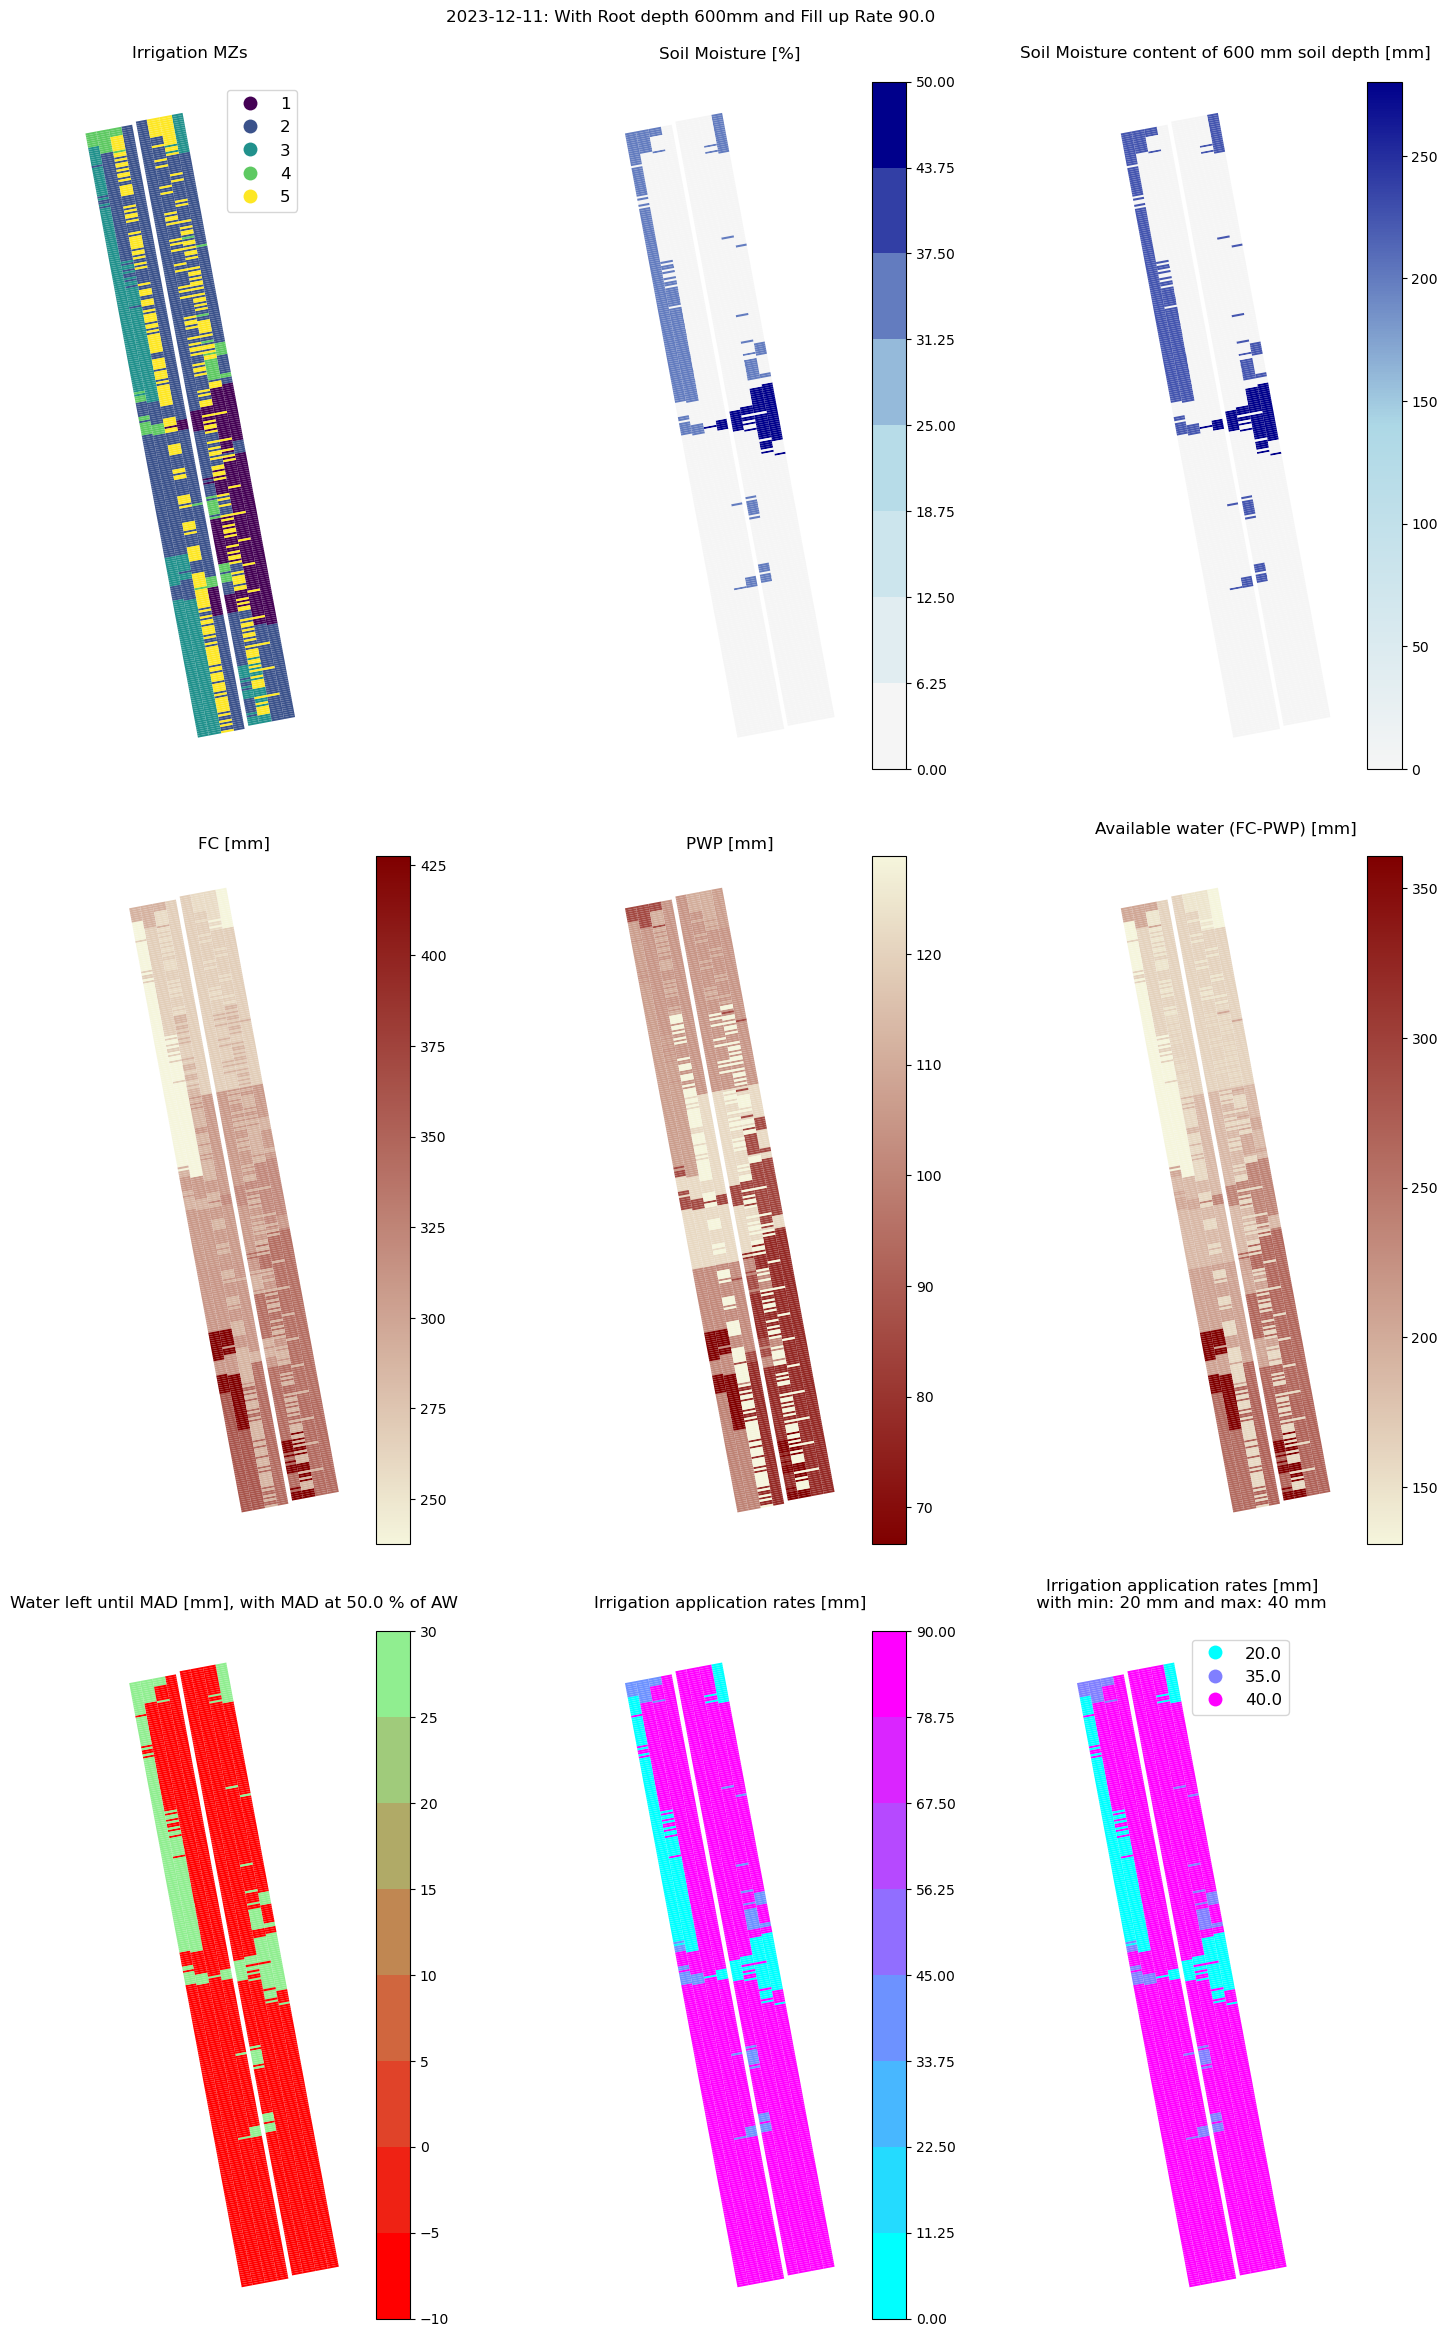

In [ ]:
    ## Irrigation Plots
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,24))

    # Colormaps
    colorFC  = LinearSegmentedColormap.from_list("", ['beige','maroon'])
    colorPWP = LinearSegmentedColormap.from_list("", ['maroon','beige'])
    colorIN  = LinearSegmentedColormap.from_list("", ['lightblue','darkblue'])
    colorSMC = LinearSegmentedColormap.from_list("", ['whitesmoke','lightblue','darkblue'])   
    colorWL  = LinearSegmentedColormap.from_list("", ['red','lightgreen'])


    # define bounds
    boundsFC  = np.linspace(100, 200, 9)    
    boundsPWP = np.linspace(20, 80, 9)
    boundsIN  = np.linspace(0, 90, 9)
    boundsSMC = np.linspace(0, 50, 9)
    boundsWL  = np.linspace(-10, 30, 9)
    
    # define bins and normalize    
    normFC  = mpl.colors.BoundaryNorm(boundsFC,  colorFC.N)
    normPWP = mpl.colors.BoundaryNorm(boundsPWP, colorPWP.N)
    normIN  = mpl.colors.BoundaryNorm(boundsIN,  colorIN.N)
    normSMC = mpl.colors.BoundaryNorm(boundsSMC, colorSMC.N)
    normWL  = mpl.colors.BoundaryNorm(boundsWL,  colorWL.N)

    
    legend_set =  {'loc': 'upper right', 'prop': {'size': 12}}
    gdf.plot(ax=axs[0,0], column="irr_mz",  cmap="viridis",legend="TRUE", categorical="true",legend_kwds=legend_set)
    gdf.plot(ax=axs[0,1], column="smc",     cmap=colorSMC,legend="TRUE",norm=normSMC)
    gdf.plot(ax=axs[0,2], column="CMC_mm",  cmap=colorSMC,legend="TRUE")
    gdf.plot(ax=axs[1,0], column="FC_mm",   cmap=colorFC,legend="TRUE")
    gdf.plot(ax=axs[1,1], column="PWP_mm",  cmap=colorPWP,legend="TRUE")
    gdf.plot(ax=axs[1,2], column="AW_mm",   cmap=colorFC,legend="TRUE")
    gdf.plot(ax=axs[2,0], column="WL_mm",   cmap=colorWL,legend="TRUE",norm=normWL)
    gdf.plot(ax=axs[2,1], column="IN_mm",   cmap='cool',legend="TRUE",norm=normIN)
    gdf.plot(ax=axs[2,2], column="Irr_mm",cmap='cool',legend="TRUE", categorical="true",legend_kwds=legend_set)

    axs[0,0].set_title("Irrigation MZs")
    axs[0,1].set_title("Soil Moisture [%]")
    axs[0,2].set_title(f"Soil Moisture content of {str(depth[i])} mm soil depth [mm]")
    axs[1,0].set_title("FC [mm]")
    axs[1,1].set_title("PWP [mm]")
    axs[1,2].set_title("Available water (FC-PWP) [mm]")
    axs[2,0].set_title(f"Water left until MAD [mm], with MAD at {str(MAD_set[i]*100)} % of AW")
    axs[2,1].set_title("Irrigation application rates [mm]")
    axs[2,2].set_title(f"Irrigation application rates [mm]\n with min: {str(Irr_min[i])} mm and max: {str(Irr_max[i])} mm ")
    
    axs[0,0].axis("off")
    axs[0,1].axis("off")
    axs[0,2].axis("off")
    axs[1,0].axis("off")
    axs[1,1].axis("off")
    axs[1,2].axis("off")
    axs[2,0].axis("off")
    axs[2,1].axis("off")
    axs[2,2].axis("off")
    
    fig.suptitle(str(date.today()) + ": With Root depth "+ str(depth[i]) +"mm and Fill up Rate "+str(fill_up_rate[i]*100)) 
    
    plt.tight_layout(pad=2.5)
    
    plt.savefig("outputFiles/" + field[i] + "_irr_bins.png")
    #plt.show()

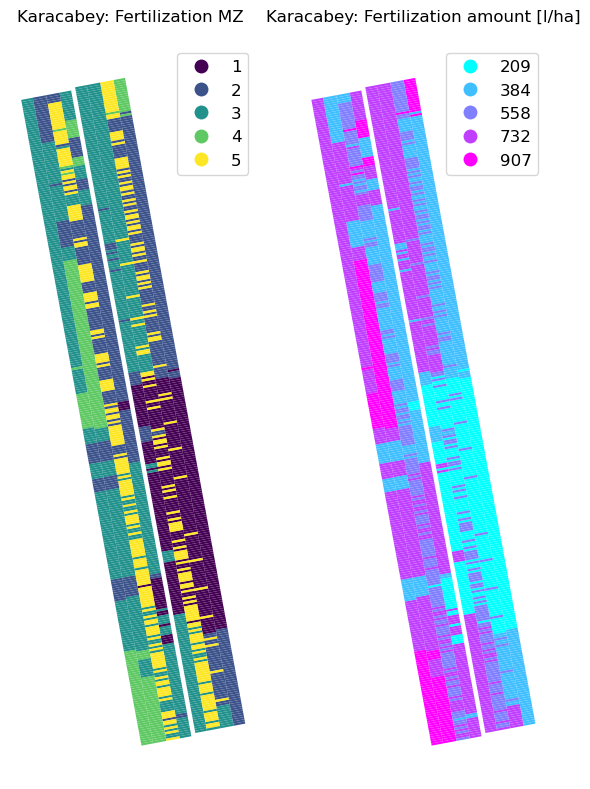

In [ ]:
    ## Fertilization Plots
    plotsize = [18,8,8]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,8))

    legend_set =  {'loc': 'upper right', 'prop': {'size': 12}}
    gdf.plot(ax=axs[0], column="fer_mz",cmap='viridis', legend="TRUE",categorical="true",legend_kwds=legend_set)
    gdf.plot(ax=axs[1], column="fer_l_ha",cmap='cool',legend="TRUE",categorical="true",legend_kwds=legend_set)

    axs[0].set_title(field[i] + ": Fertilization MZ ")
    axs[1].set_title(field[i] + ": Fertilization amount [l/ha]")     
    
    axs[0].axis("off")
    axs[1].axis("off")
    
    #axs[0].legend(loc='upper center',legend="TRUE")
    
    plt.tight_layout()
    
    plt.savefig("outputFiles/" + field[i] + "_fer.png")

In [ ]:
    #print(gdf.crs)

    # Create a new directory if it does not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # reduce the dataframe
    gdf_out = gdf[['fer_l_ha','irr_l_ha','IN_mm','row', 'column', 'field_id','geometry']]
    gdf_out = gdf_out.rename(columns={"IN_mm":"irr_mm"})

    # Export as Shapefile
    gdf_out.to_file(folder, driver='ESRI Shapefile')

    # Export as GeoJson
    gdf_out.to_file(folder+".geojson", driver="GeoJSON")

    # create zip file)
    shutil.make_archive(folder, 'zip', folder)

'/home/alex/ADDFerti/fertigationMap/fertigationMap/outputFiles/bursa_application_map.zip'

In [ ]:
    # Upload to geonode
    try:
      with open(folder +'.zip', 'rb') as f:
        data = f.read()
      url = 'https://geoportal.addferti.eu/geoserver/rest/workspaces/'    
      response = requests.put(
        url + 'geonode/datastores/' + filename + '/file.shp',
        headers={'Content-type': 'application/zip'},
        data=data,
        verify=False,
        auth=('admin', 'geoserver')
        )
      print(folder +'.zip uploaded' )
    except FileNotFoundError:
      print(folder + " file not found")

outputFiles/bursa_application_map.zip uploaded


/home/alex/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geoportal.addferti.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
    ## Export "Water left until MAD" as a matrix
    # Extract centroids of polygon and transform to form: WL_mm, x, y
    gdf_wl = gdf
    gdf_wl['centroid'] = gdf_wl.centroid
    gdf_wl['x'] = gdf_wl['centroid'].x 
    gdf_wl['y'] = gdf_wl['centroid'].y 
    gdf_wl = gdf_wl[['WL_mm','x','y']]
    gdf_wl

    filename = "outputFiles/water_left_" + uni[i] + ".txt"
    gdf_wl.to_csv(filename)
    # Reproject to WGS84 + longlat
    #wl_raster_idw = projectRaster(wl_raster_idw, crs="+proj=longlat +datum=WGS84")

    # Transform Raster to Point matrix with format: "x, y, value"
    #wl_matrix_idw = rasterToPoints(wl_raster_idw, spatial=False)
    #wl_matrix_idw.columns = ["x", "y", "wl"]

    #filename = "water_left_" + university[i] + ".txt"
    #wl_matrix_idw.to_csv(filename, sep=",", index=False)